In [1]:
from pystac_client import Client
import stackstac

import warnings
warnings.filterwarnings('ignore')

In [2]:
box = [-122.51006, 37.70801, -122.36268, 37.80668]
client = Client.open("https://earth-search.aws.element84.com/v1")
search = client.search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2022-06-01/2022-08-01",
    query={"eo:cloud_cover": {"lt": 20}}
)

In [3]:
items = search.get_all_items()
stack = stackstac.stack(items, bounds_latlon=box)
stack

<xarray.DataArray 'stackstac-f9b2870f62549338f0f5c7ff668ad1a9' (time: 3,
                                                                band: 32,
                                                                y: 1103, x: 1306)>
dask.array<fetch_raster_window, shape=(3, 32, 1103, 1306), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-06-13...
    id                                       (time) <U24 'S2A_10SEG_20220613_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5.431e+05 ... 5.562e+05
  * y                                        (y) float64 4.185e+06 ... 4.174e+06
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(543120.0, 4173530.0, 556180.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 543120.00|\n| 0.00,-10.00, 4184560.00|\n| 0.0...
    resolution:  10.0

In [4]:
red = stack.sel(band="red")
nir = stack.sel(band="nir")

In [18]:
print("computing ndvi...")
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    ndvi = ( ((nir - red) / (red + nir)).
            resample(time="MS").
            median("time", keep_attrs=True).
            compute()
    )

computing ndvi...
[#                                       ] | 2% Completed | 104.73 ms

[########################################] | 100% Completed | 5.46 ss


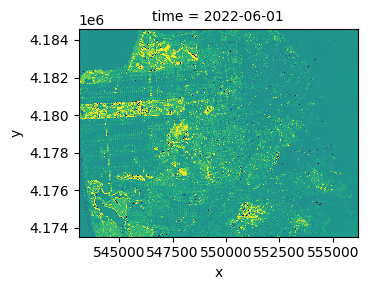

In [19]:
ndvi.plot.imshow(row="time", cmap="viridis", robust=True, add_colorbar=False)


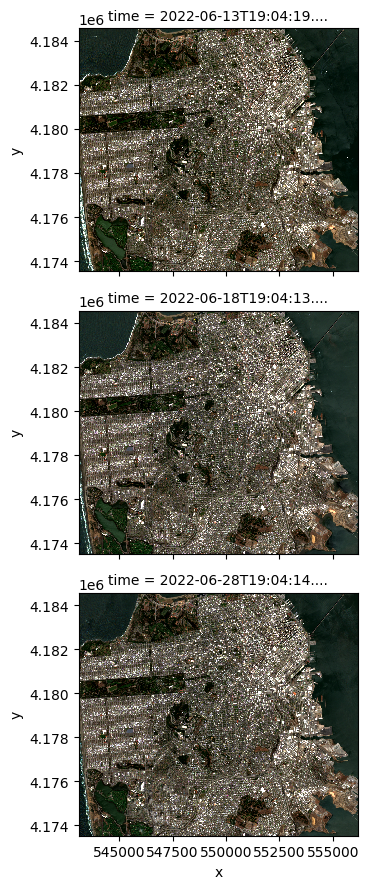

In [20]:

# True-color image, over time
rgb = stack.sel(band=["red", "green", "blue"])
rgb.plot.imshow(row="time", robust=True, add_colorbar=False)



In [12]:
import rioxarray
ndvi.rio.to_raster("ndvi.tif", driver="COG")
